In [1]:
import sys
from pathlib import Path

# allow src folder to be imported from this notebook
module_path = str(Path.cwd().parents[0])
if module_path not in sys.path:
    sys.path.append(module_path)

### EDA MSAs
___

In [2]:
import pandas as pd
import seaborn as sns

PATH_EDA = Path("../output/analysis-msa")

In [3]:
eda_msas = pd.read_csv(PATH_EDA.joinpath("stats_msas.tsv"),sep="\t", index_col=False)
eda_msas.drop_duplicates(subset="path_msa", inplace=True,)

In [11]:
eda_msas.describe()

,n_seqs,n_unique_seqs,n_identical_cols,n_cols,perc_identical_cols
count,37423.000000,37423.000000,37423.000000,37423.000000,37423.000000
mean,52.208562,8.711835,520.590305,550.403495,95.766866
std,97.350875,17.090313,596.563078,635.772178,6.938166
min,1.000000,1.000000,25.000000,30.000000,30.770000
25%,1.000000,1.000000,169.000000,177.000000,93.230000
50%,4.000000,2.000000,312.000000,327.000000,99.800000
75%,40.000000,6.000000,692.000000,738.000000,100.000000
max,2352.000000,366.000000,13377.000000,13377.000000,100.000000


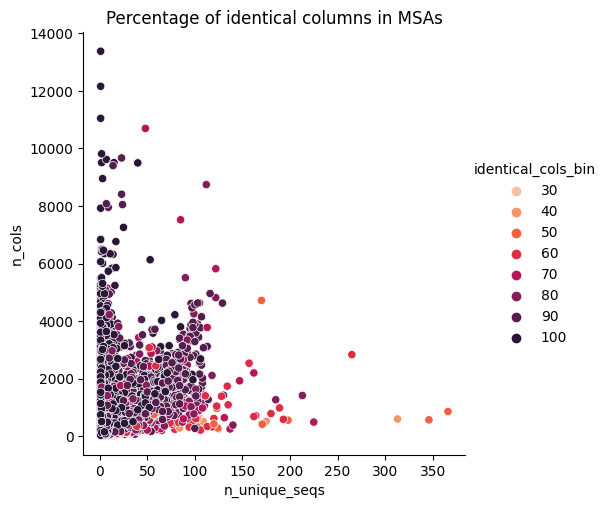

In [22]:
# percentage of identical columns vs (number of unique sequences and number of columns)
levels=range(20,101,10) # the level is set to consider the minimum
eda_msas["identical_cols_bin"] = pd.cut(eda_msas["perc_identical_cols"],
                                    bins=levels,
                                    labels=[l for l in levels[1:]]
                                    )
plot = sns.relplot(
    data=eda_msas, 
    x="n_unique_seqs", 
    y="n_cols", 
    hue="identical_cols_bin",
    palette=sns.color_palette("rocket_r",len(levels)-1)
    )
plot.set(title="Percentage of identical columns in MSAs")

## Maximal Blocks
___ 
Plot the distribution of the maximal blocks in 
- one MSA
- a set of MSAs
The idea is to see how large are the maximal blocks

In [23]:
import json
from src.blocks import Block
from collections import namedtuple


**One MSA**

In [25]:
path_max_blocks = Path("../output2/max_blocks/GC00002971_r1_r1_1.json")
name_msa = path_max_blocks.stem
# load max blocks
with open(path_max_blocks) as fp: 
    max_blocks = json.load(fp)
max_blocks = [Block(*block) for block in max_blocks]
len(max_blocks)

# get size (of set K) and length (of string: j-i+1)
mb_info = namedtuple("MBInfo", ["id_block","size","len"])

sl = []
for j, block in enumerate(max_blocks): 
    size_block = len(block.K)
    len_block  = block.j - block.i + 1
    sl.append( mb_info(j, size_block, len_block) )

[Text(0.5, 1.0, 'distribution of max blocks | MSA GC00002971_r1_r1_1')]

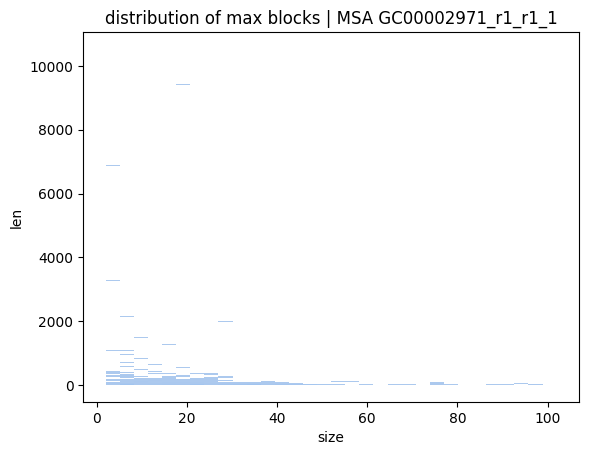

In [26]:
data = pd.DataFrame(sl)
hist_max_block = sns.histplot(
    data=data, x="size", y="len", 
    stat="density")
hist_max_block.set(title=f"distribution of max blocks | MSA {name_msa}")

**All MSAs**

In [33]:
from rich.progress import track
from tqdm.notebook import tqdm
# path to maximal blocks
paths_mb = list(Path("../output-exp/max_blocks/").rglob("*json"))

In [34]:
sl = []
for path in track(paths_mb): 

    with open(path_max_blocks) as fp: 
        max_blocks = json.load(fp)
    max_blocks = [Block(*block) for block in max_blocks]

    # get size (of set K) and length (of string: j-i+1)
    mb_info = namedtuple("MBInfo", ["id_block","size","len"])

    for j, block in enumerate(max_blocks): 
        size_block = len(block.K)
        len_block  = block.j - block.i + 1
        sl.append( mb_info(j, size_block, len_block) )

Output()

[Text(0.5, 1.0, 'distribution of max blocks | MSA GC00002971_r1_r1_1')]

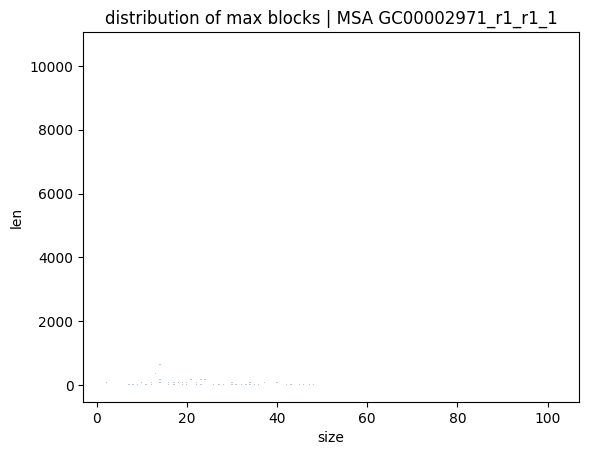

In [35]:
data = pd.DataFrame(sl)
hist_max_block = sns.histplot(
    data=data, x="size", y="len", 
    stat="density")
hist_max_block.set(title=f"distribution of max blocks")

In [37]:
data.describe()

,id_block,size,len
count,7.800000e+06,7.800000e+06,7.800000e+06
mean,3.899500e+03,2.801756e+01,9.503654e+01
std,2.251666e+03,1.761117e+01,5.710958e+02
min,0.000000e+00,2.000000e+00,1.000000e+00
25%,1.949750e+03,1.200000e+01,2.000000e+00
50%,3.899500e+03,2.700000e+01,4.000000e+00
75%,5.849250e+03,4.300000e+01,3.500000e+01
max,7.799000e+03,1.020000e+02,1.053100e+04


In [95]:
levels_size=range(0,max(data["size"])+1)
data["size_bin"] = pd.cut(data["size"],
                        bins=levels_size,
                        labels=[l for l in levels_size[1:]]
                        )

levels_len=range(0,max(data["len"])+100,100)
data["len_bin"] = pd.cut(data["len"],
                        bins=levels_len,
                        labels=[l for l in levels_len[1:]]
                        )

In [96]:
# data = pd.DataFrame(sl)
# hist_max_block = sns.histplot(
#     data=data, x="size_bin", y="len_bin", 
#     stat="density")
# hist_max_block.set(title=f"distribution of max blocks")

In [97]:
records = data.to_dict("records")

In [100]:
import numpy as np 

cat_size_to_idx = {j:c for j,c in enumerate(data["size_bin"].cat.categories)}
cat_len_to_idx  = {j:c for j,c in enumerate(data["len_bin"].cat.categories)}
data_heatmap=np.zeros((data["size_bin"].max()+1, data["len_bin"].max()+2))
for row in records: 
    size=row.get("size_bin")
    len=row.get("len_bin")

    idx_cat_size = cat_size_to_idx.get(size)
    idx_cat_len  = cat_len_to_idx.get(len)
    data_heatmap[idx_cat_size,idx_cat_len]+=1

IndexError: index 10100 is out of bounds for axis 0 with size 103

In [101]:
idx_cat_size,idx_cat_len

(None, 10100)

<AxesSubplot: >

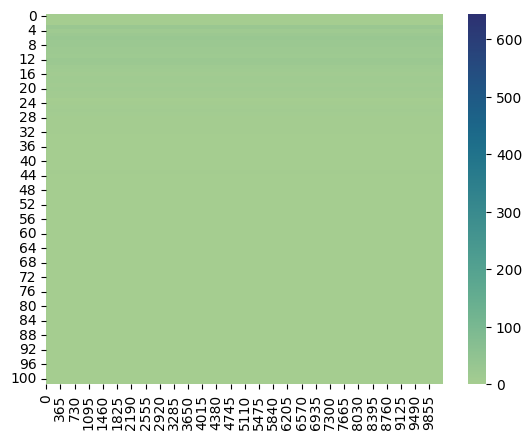

In [88]:
sns.heatmap(
    data_heatmap,
    cmap="crest",#sns.color_palette("rocket_r"),
)